In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import xgboost as xg
import joblib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = "D:/ML/EXPLO/Explo_New_Data/Explo_New_Data/"
files = os.listdir(DATA_DIR)

In [3]:
def data_generator():
    data = pd.DataFrame({}, columns = ['X_Coordinate', 'Y_Coordinate', 'Pressure', 'Total_Pressure',
       'Velocity_Magnitude', 'Axial_velocity', 'Temperature',
       'Total_Temperature', 'Total_energy', 'Cell_Volume', 'Flux',
       'Inlet_Temperature'] )
    
    f1 = pd.DataFrame({"FILES":files})
    split1 = f1["FILES"].str.split(pat = "_", expand = True)
    temp = split1[0].str.split(pat = "K", expand = True)
    flux = split1[1].str.split(pat = ".", expand = True)
    temp[0] = temp[0].astype(int)
    flux[0] = flux[0].astype(int)
    
    for i in range(0, len(files)):
        path = DATA_DIR + files[i]
        data2 = pd.read_csv(path)
        data2["Flux"] = (flux[0][i])*np.ones((2943,))
        data2["Inlet_Temperature"] = (temp[0][i])*np.ones((2943,))
        data = pd.concat([data, data2])
    data.reset_index(drop = True, inplace = True)
    
    for i in data.columns:
        data[i] = data[i].astype(float)
    
    data = data[[ "X_Coordinate", "Y_Coordinate", "Inlet_Temperature", "Flux" ,
                 "Pressure", "Velocity_Magnitude", "Total_Temperature", "Total_energy" ]]
    return data

data = data_generator()
data

,X_Coordinate,Y_Coordinate,Inlet_Temperature,Flux,Pressure,Velocity_Magnitude,Total_Temperature,Total_energy
0,0.000,0.000000e+00,283.0,400.0,-0.439741,0.000000,360.053,-41223.1
1,0.002,-1.224610e-19,283.0,400.0,-0.436783,0.004329,358.194,-42555.6
2,0.004,-2.449210e-19,283.0,400.0,-0.432804,0.009982,355.706,-44338.4
3,0.006,-3.673820e-19,283.0,400.0,-0.428930,0.016906,354.666,-45083.7
4,0.008,-4.898430e-19,283.0,400.0,-0.425230,0.024767,353.936,-45606.6
...,...,...,...,...,...,...,...,...
353155,0.030,1.496000e+00,316.0,850.0,-0.012970,0.152258,316.000,-72790.8
353156,0.060,1.498000e+00,316.0,850.0,0.000763,0.000000,316.000,-72790.8
353157,0.030,1.498000e+00,316.0,850.0,-0.012895,0.151980,316.000,-72790.8
353158,0.030,1.500000e+00,316.0,850.0,-0.012879,0.151834,316.000,-72790.8


Text(0.5, 1.0, 'FLUX VS PRESSURE')

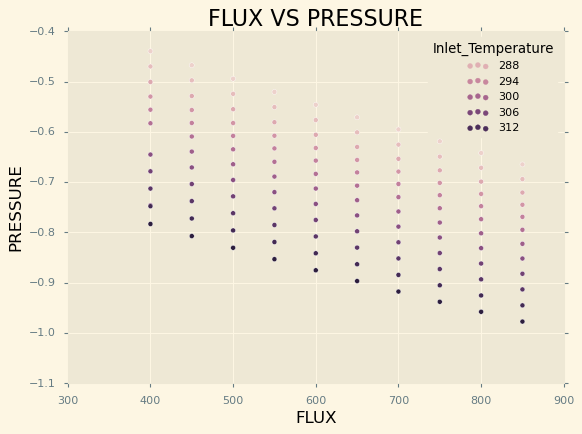

In [121]:
sns.scatterplot(data=data[data.index % 2943 == 0],
                x='Flux', y='Pressure', hue='Inlet_Temperature')
plt.xlabel("FLUX", size = 15, color = "black")
plt.ylabel("PRESSURE", size = 15, color = "black")
plt.title("FLUX VS PRESSURE", size = 20, color = "black")

Text(0.5, 1.0, 'CORRELATION MATRIX')

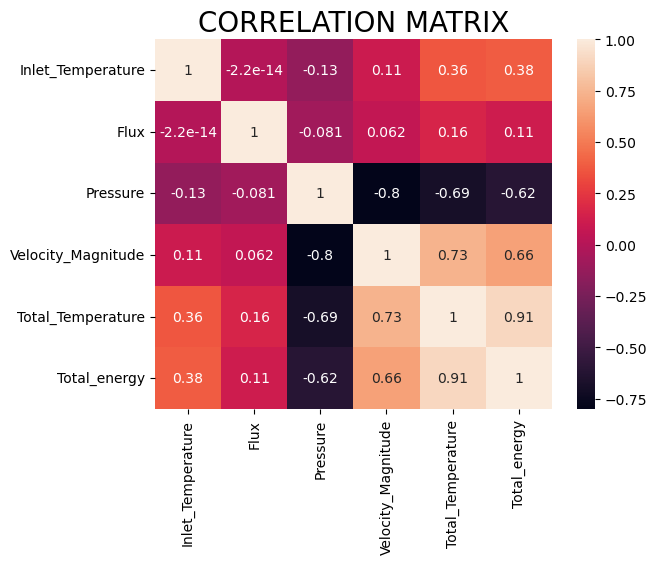

In [38]:
pl = sns.heatmap(data[["Inlet_Temperature", "Flux", "Pressure", "Velocity_Magnitude", "Total_Temperature", "Total_energy"]].corr(), 
            annot = True )
plt.title("CORRELATION MATRIX", size = 20)

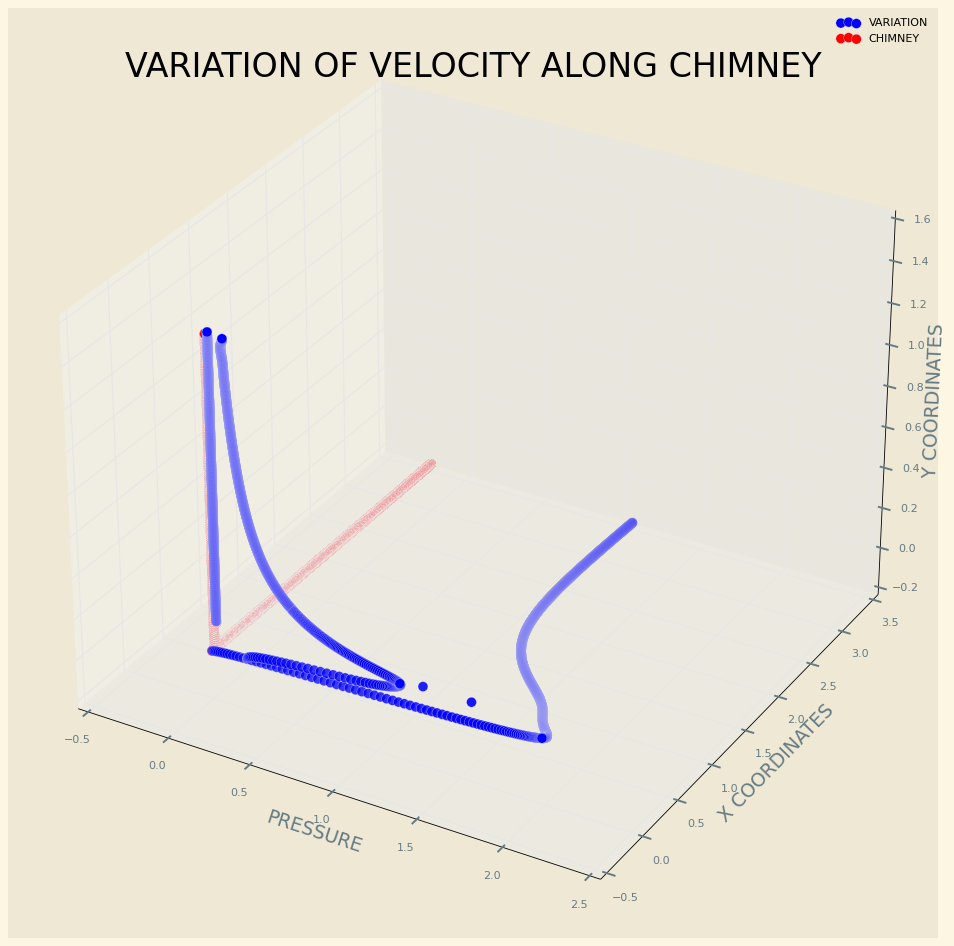

In [112]:
plt.style.use("seaborn-notebook") 
fig = plt.figure(figsize= (15, 15))
ax = plt.axes(projection = "3d")

x = data.iloc[:2943,:]["Velocity_Magnitude"]
y = data.iloc[:2943,:]["X_Coordinate"]
z =data.iloc[:2943,:]["Y_Coordinate"]

ax.scatter3D(x, y, z, s = 80, label = "VARIATION", c = "blue", marker = "o")
ax.scatter3D(np.zeros(len(data)), data["X_Coordinate"],
             data["Y_Coordinate"], label = "CHIMNEY", s = 80,  c = "red", marker = "o")
plt.xlabel("PRESSURE", size = 17)
plt.ylabel("X COORDINATES", size = 17)
ax.set_zlabel("Y COORDINATES",  size = 17)
plt.title("VARIATION OF VELOCITY ALONG CHIMNEY", size = 30, color = "black")
plt.legend();

## XG BOOST REGRESSOR

In [29]:
x = data[["X_Coordinate", "Y_Coordinate", "Inlet_Temperature", "Flux"  ]]
y = data[["Pressure", "Velocity_Magnitude", "Total_Temperature", "Total_energy"]]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size= 0.2, random_state = 42)

In [30]:
model = xg.XGBRegressor()
model.fit(xtrain, ytrain)
score =  model.score(xtest, ytest)
pred = model.predict(xtest)
mse = mean_squared_error(ytest, pred)
rmse = math.sqrt(mse)
joblib.dump(model, 'xg.pkl')
print("THE ROOT MEAN SQUARED ERROR IS :" , rmse)
print("==============================================")
print("THE ACCURACY SCORE IS :", score*100)

THE ROOT MEAN SQUARED ERROR IS : 142.09840974074
THE ACCURACY SCORE IS : 99.96531248884695


## KNN REGRESSOR

In [6]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(xtrain, ytrain)
score = neigh.score(xtest, ytest)
pred = neigh.predict(xtest)
mse = mean_squared_error(ytest, pred)
rmse = math.sqrt(mse)
print("THE ROOT MEAN SQUARED ERROR IS :" , rmse)
print("==============================================")
print("THE ACCURACY SCORE IS :", score*100)

THE ROOT MEAN SQUARED ERROR IS : 73.91172236922492
THE ACCURACY SCORE IS : 99.8580563475335


## RANDOM FOREST REGRESSOR

In [7]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(xtrain, ytrain)
score = rfr.score(xtest, ytest)
pred = rfr.predict(xtest)
mse = mean_squared_error(ytest, pred)
rmse = math.sqrt(mse)
print("THE ROOT MEAN SQUARED ERROR IS :" , rmse)
print("==============================================")
print("THE ACCURACY SCORE IS :", score*100)

THE ROOT MEAN SQUARED ERROR IS : 29.404623367916674
THE ACCURACY SCORE IS : 99.98610576239736


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError

ann = Sequential()
ann.add(Dense(32, activation='relu', input_shape=(4,)))
ann.add(Dense(64, activation='relu'))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(4))
ann.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])
ann.fit(xtrain, ytrain, epochs = 25, batch_size = 64, validation_split=0.2)

Epoch 1/25
3532/3532 [==============================] - 7s 2ms/step - loss: 86164832.0000 - root_mean_squared_error: 9282.5010 - val_loss: 45481456.0000 - val_root_mean_squared_error: 6743.9941
Epoch 2/25
3532/3532 [==============================] - 6s 2ms/step - loss: 43807824.0000 - root_mean_squared_error: 6618.7480 - val_loss: 40579428.0000 - val_root_mean_squared_error: 6370.1982
Epoch 3/25
3532/3532 [==============================] - 7s 2ms/step - loss: 37582608.0000 - root_mean_squared_error: 6130.4653 - val_loss: 33226984.0000 - val_root_mean_squared_error: 5764.2852
Epoch 4/25
3532/3532 [==============================] - 7s 2ms/step - loss: 31016070.0000 - root_mean_squared_error: 5569.2070 - val_loss: 29725314.0000 - val_root_mean_squared_error: 5452.0928
Epoch 5/25
3532/3532 [==============================] - 6s 2ms/step - loss: 28217916.0000 - root_mean_squared_error: 5312.0537 - val_loss: 27393132.0000 - val_root_mean_squared_error: 5233.8447
Epoch 6/25
3532/3532 [========

## SINGLE CELL PREDICTION

In [3]:
def making_predictions(inlet_temp, flux, x_coordinate , y_coordinate):
    input_df = pd.DataFrame({"X_Coordinate": x_coordinate, "Y_Coordinate": y_coordinate, "Inlet_Temperature":inlet_temp, "Flux" : flux }, index = [0])
    model= joblib.load("xg.pkl")
    pred = model.predict(input_df)
        
    pred_df = pd.DataFrame(pred, index = [0])
    pred_df.columns = ['Pressure', 'Velocity_Magnitude', 'Total_Temperature', 'Total_energy']
    return pred_df

In [4]:
# PREDICTIONS
inlet_temp = int(input("ENTER INLET TEMPERATURE: ")) 
flux = int(input("ENTER FLUX: "))
x_coordinate =  float(input("ENTER X COORDINATE: "))
y_coordinate =  float(input("ENTER Y COORDINATE: "))

pred_df = making_predictions(inlet_temp = inlet_temp, flux = flux, x_coordinate =  x_coordinate, y_coordinate =  y_coordinate)
pred_df

ENTER INLET TEMPERATURE: 283
ENTER FLUX: 400
ENTER X COORDINATE: 0.03
ENTER Y COORDINATE: 1.5


,Pressure,Velocity_Magnitude,Total_Temperature,Total_energy
0,-0.002164,0.090266,283.108215,-96418.09375


In [5]:
# REAL VALUES
data1 = pd.read_csv(f"D:/ML/EXPLO/Explo_New_Data/Explo_New_Data/{inlet_temp}K_{flux}.csv")
data2 = data1[(data1["X_Coordinate"] == x_coordinate) & (data1["Y_Coordinate"] == y_coordinate)]
data2.reset_index(inplace = True, drop = True)
data2 = data2[["Pressure", "Velocity_Magnitude", "Total_Temperature", "Total_energy"]]
data2

,Pressure,Velocity_Magnitude,Total_Temperature,Total_energy
0,-0.006714,0.103684,283.0,-96437.7


## FULL CHIMNEY PREDICTION

In [6]:
def full_prediction(inlet_temp , flux):
    model = joblib.load("xg.pkl")
    pred = model.predict(point_df)
    pred_df = pd.DataFrame(pred)
    pred_df.columns = ['Pressure', 'Velocity_Magnitude', 'Total_Temperature', 'Total_energy']
    
    return pred_df

In [7]:
inlet_temp = int(input("ENTER INLET TEMPERATURE: ")) 
flux = int(input("ENTER FLUX: "))

sam = pd.read_csv("D:/ML/EXPLO/Explo_New_Data/Explo_New_Data/283K_400.csv")
point_df = sam[["X_Coordinate", "Y_Coordinate"]]
point_df["Inlet_Temperature"] = (inlet_temp)*np.ones((2943,))
point_df["Flux"] = (flux)*np.ones((2943,))

pred_df = full_prediction(inlet_temp = inlet_temp, flux = flux)
final_df = pd.concat([point_df, pred_df], axis = 1)
final_df

ENTER INLET TEMPERATURE: 313
ENTER FLUX: 800


,X_Coordinate,Y_Coordinate,Inlet_Temperature,Flux,Pressure,Velocity_Magnitude,Total_Temperature,Total_energy
0,0.000,0.000000e+00,313.0,800.0,-0.918212,0.001402,394.102325,-16881.718750
1,0.002,-1.224610e-19,313.0,800.0,-0.916677,0.004542,391.632538,-18600.833984
2,0.004,-2.449210e-19,313.0,800.0,-0.913071,0.010387,388.885895,-20807.111328
3,0.006,-3.673820e-19,313.0,800.0,-0.909665,0.022134,387.754669,-21475.376953
4,0.008,-4.898430e-19,313.0,800.0,-0.901709,0.032885,386.866028,-21717.583984
...,...,...,...,...,...,...,...,...
2938,0.030,1.496000e+00,313.0,800.0,-0.014148,0.145751,313.065155,-74975.703125
2939,0.060,1.498000e+00,313.0,800.0,-0.002446,-0.000785,313.132385,-74917.539062
2940,0.030,1.498000e+00,313.0,800.0,-0.014148,0.145751,313.065155,-74975.703125
2941,0.030,1.500000e+00,313.0,800.0,-0.014148,0.145751,313.065155,-74975.703125


In [8]:
data1 = pd.read_csv(f"D:/ML/EXPLO/Explo_New_Data/Explo_New_Data/{inlet_temp}K_{flux}.csv")
data1["Inlet_Temperature"] = (inlet_temp)*np.ones((2943,))
data1["Flux"] = (flux)*np.ones((2943,))
data2 = data1[final_df.columns]
data2

,X_Coordinate,Y_Coordinate,Inlet_Temperature,Flux,Pressure,Velocity_Magnitude,Total_Temperature,Total_energy
0,0.000,0.000000e+00,313.0,800.0,-0.925490,0.000000,394.304,-16679.6
1,0.002,-1.224610e-19,313.0,800.0,-0.921108,0.005719,391.941,-18373.0
2,0.004,-2.449210e-19,313.0,800.0,-0.915130,0.013463,388.876,-20569.6
3,0.006,-3.673820e-19,313.0,800.0,-0.909293,0.023134,387.699,-21412.8
4,0.008,-4.898430e-19,313.0,800.0,-0.903733,0.034332,386.851,-22020.4
...,...,...,...,...,...,...,...,...
2938,0.030,1.496000e+00,313.0,800.0,-0.011921,0.145338,313.000,-74940.5
2939,0.060,1.498000e+00,313.0,800.0,-0.000134,0.000000,313.000,-74940.5
2940,0.030,1.498000e+00,313.0,800.0,-0.011853,0.145052,313.000,-74940.5
2941,0.030,1.500000e+00,313.0,800.0,-0.011842,0.144905,313.000,-74940.5
